In [1]:
MAX_TIME = 1 # Time in minutes. Counter starts, after the initial design is evaluated. So, runtime can be larger.
INIT_SIZE = 10 # Initial number of designs to evaluate, before the surrogate is build.

In [2]:
import pickle
import socket
from datetime import datetime
from dateutil.tz import tzlocal
start_time = datetime.now(tzlocal())
HOSTNAME = socket.gethostname().split(".")[0]
experiment_name = '10-sklearn' + "_" + HOSTNAME + "_" + str(MAX_TIME) + "min_" + str(INIT_SIZE) + "init_" + str(start_time).split(".", 1)[0].replace(' ', '_')
experiment_name = experiment_name.replace(':', '-')
experiment_name

'10-sklearn_p058165_1min_10init_2023-05-09_16-38-00'

# Chapter 10: Sequential Parameter Optimization
## Hyperparameter Tuning: sklearn

* This notebook exemplifies hyperparameter tuning with SPOT (spotPython).
* The hyperparameter software SPOT was developed in R (statistical programming language), see Open Access book "Hyperparameter Tuning for Machine and Deep Learning with R - A Practical Guide", available here: [https://link.springer.com/book/10.1007/978-981-19-5170-1](https://link.springer.com/book/10.1007/978-981-19-5170-1).


In [3]:
pip list | grep  "spot[RiverPython]"

spotPython                                0.0.64
spotRiver                                 0.0.81
Note: you may need to restart the kernel to use updated packages.


In [4]:
# import sys
# !{sys.executable} -m pip install --upgrade build
# !{sys.executable} -m pip install --upgrade --force-reinstall spotPython

In [5]:
from tabulate import tabulate
import warnings
import numpy as np
from math import inf
import pandas as pd

from scipy.optimize import differential_evolution

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder , MinMaxScaler, StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline , Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.datasets import fetch_openml
from sklearn.metrics import mean_absolute_error, accuracy_score, roc_curve, roc_auc_score, log_loss, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet

warnings.filterwarnings("ignore")

from spotPython.spot import spot
from spotPython.hyperparameters.values import (
    add_core_model_to_fun_control,
    assign_values,
    convert_keys,
    get_bound_values,
    get_default_hyperparameters_for_core_model,
    get_default_values,
    get_dict_with_levels_and_types,
    get_values_from_dict,
    get_var_name,
    get_var_type,
    iterate_dict_values,
    modify_hyper_parameter_levels,
    modify_hyper_parameter_bounds,
    replace_levels_with_positions,
    return_conf_list_from_var_dict,
    get_one_core_model_from_X,
    transform_hyper_parameter_values,
    get_dict_with_levels_and_types,
    convert_keys,
    iterate_dict_values,
    get_one_sklearn_model_from_X
)

from spotPython.utils.convert import class_for_name
from spotPython.utils.eda import (
    get_stars,
    gen_design_table)
from spotPython.utils.transform import transform_hyper_parameter_values
from spotPython.utils.convert import get_Xy_from_df
from spotPython.plot.validation import plot_cv_predictions, plot_roc, plot_confusion_matrix
from spotPython.utils.init import fun_control_init

from spotPython.data.sklearn_hyper_dict import SklearnHyperDict
from spotPython.fun.hypersklearn import HyperSklearn
from spotPython.utils.metrics import mapk, apk

## 0. Initialization of the Empty `fun_control` Dictionary

In [6]:
fun_control = fun_control_init()

## 1. Load Data: Classification

* Randomly generate classification data.

In [7]:
n_features = 2
n_samples = 250
target_column = "y"
ds =  make_moons(n_samples, noise=0.5, random_state=0)
X, y = ds
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)
train = pd.DataFrame(np.hstack((X_train, y_train.reshape(-1, 1))))
test = pd.DataFrame(np.hstack((X_test, y_test.reshape(-1, 1))))
train.columns = [f"x{i}" for i in range(1, n_features+1)] + [target_column]
test.columns = [f"x{i}" for i in range(1, n_features+1)] + [target_column]
train.head()

,x1,x2,y
0,1.083978,-1.246111,1.0
1,0.074916,0.868104,0.0
2,-1.668535,0.751752,0.0
3,1.286597,1.454165,0.0
4,1.387021,0.448355,1.0


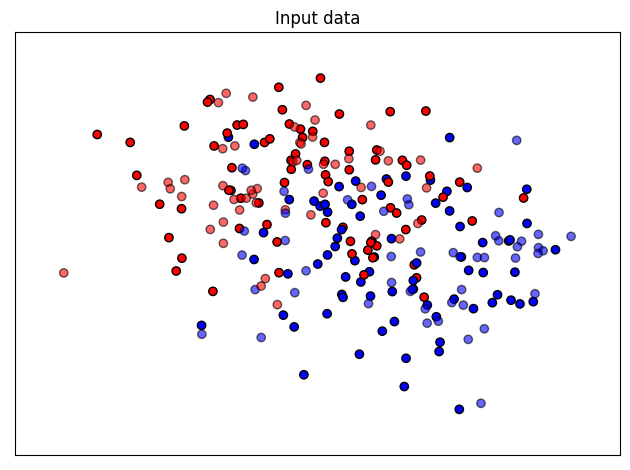

In [8]:
from matplotlib.colors import ListedColormap
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])
ax = plt.subplot(1, 1, 1)
ax.set_title("Input data")
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
# Plot the testing points
ax.scatter(
    X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())

plt.tight_layout()
plt.show()

In [9]:
n_samples = len(train)
# add the dataset to the fun_control
fun_control.update({"data": None, # dataset,
               "train": train,
               "test": test,
               "n_samples": n_samples,
               "target_column": target_column})


## 2. Specification of the Preprocessing Model

Data preprocesssing can be very simple, e.g., you can ignore it. Then you would choose the `prep_model` "None":

In [10]:
prep_model = None
fun_control.update({"prep_model": prep_model})

A default approach for numerical data is the `StandardScaler` (mean 0, variance 1).  This can be selected as follows:

In [11]:
prep_model = StandardScaler()
fun_control.update({"prep_model": prep_model})

Even more complicated pre-processing steps are possible, e.g., the follwing pipeline:

In [12]:
# categorical_columns = []
# one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
# prep_model = ColumnTransformer(
#         transformers=[
#             ("categorical", one_hot_encoder, categorical_columns),
#         ],
#         remainder=StandardScaler(),
#     )

## 3. Select `algorithm` and `core_model_hyper_dict`

The selection of the algorithm (ML model) that should be tuned is done by specifying the its name from the `sklearn` implementation.  For example, the `SVC` support vector machine classifier is selected as follows:

In [13]:
# core_model  = RidgeCV
# core_model = GradientBoostingRegressor
# core_model = ElasticNet
# core_model = RandomForestClassifier
core_model = SVC
# core_model = LogisticRegression
# core_model = KNeighborsClassifier
# core_model = GradientBoostingClassifier
fun_control = add_core_model_to_fun_control(core_model=core_model,
                              fun_control=fun_control,
                              hyper_dict=SklearnHyperDict,
                              filename=None)

Now `fun_control` has the information from the JSON file:

```json
    "SVC":
    {
        "C": {
            "type": "float",
            "default": 1.0,
            "transform": "None",
            "lower": 0.1,
            "upper": 10.0},
        "kernel": {
            "levels": ["linear", "poly", "rbf", "sigmoid"],
            "type": "factor",
            "default": "rbf",
            "transform": "None",
            "core_model_parameter_type": "str",
            "lower": 0,
            "upper": 3},
        "degree": {
            "type": "int",
            "default": 3,
            "transform": "None",
            "lower": 3,
            "upper": 3},
        "gamma": {
            "levels": ["scale", "auto"],
            "type": "factor",
            "default": "scale",
            "transform": "None",
            "core_model_parameter_type": "str",
            "lower": 0,
            "upper": 1},
        "coef0": {
            "type": "float",
            "default": 0.0,
            "transform": "None",
            "lower": 0.0,
            "upper": 0.0},
        "shrinking": {
            "levels": [0, 1],
            "type": "factor",
            "default": 0,
            "transform": "None",
            "core_model_parameter_type": "bool",
            "lower": 0,
            "upper": 1},
        "probability": {
            "levels": [0, 1],
            "type": "factor",
            "default": 0,
            "transform": "None",
            "core_model_parameter_type": "bool",
            "lower": 0,
            "upper": 1},
        "tol": {
            "type": "float",
            "default": 1e-3,
            "transform": "None",
            "lower": 1e-4,
            "upper": 1e-2},
        "cache_size": {
            "type": "float",
            "default": 200,
            "transform": "None",
            "lower": 100,
            "upper": 400},
        "break_ties": {
            "levels": [0, 1],
            "type": "factor",
            "default": 0,
            "transform": "None",
            "core_model_parameter_type": "bool",
            "lower": 0,
            "upper": 1}
    }
```

## 4. Modify `hyper_dict` Hyperparameters for the Selected Algorithm aka `core_model`

### Modify hyperparameter of type factor

Factors can be modified with the `modify_hyper_parameter_levels` function.  For example, to exclude the `sigmoid` kernel from the tuning, the `kernel` hyperparameter of the `SVC` model can be modified as follows:

In [14]:
fun_control = modify_hyper_parameter_levels(fun_control, "kernel", ["linear", "poly", "rbf"])
fun_control["core_model_hyper_dict"]["kernel"]

{'levels': ['linear', 'poly', 'rbf'],
 'type': 'factor',
 'default': 'rbf',
 'transform': 'None',
 'core_model_parameter_type': 'str',
 'lower': 0,
 'upper': 2}

### Modify hyperparameter of type numeric and integer (boolean)

Numeric and boolean values can be modified using the `modify_hyper_parameter_bounds` method.  For example, to change the `tolC` hyperparameter of the `SVC` model to the interval [1e-5, 1e-2], the following code can be used:

In [15]:
fun_control = modify_hyper_parameter_bounds(fun_control, "tol", bounds=[1e-5, 1e-2])
# fun_control = modify_hyper_parameter_bounds(fun_control, "min_samples_split", bounds=[3, 20])
#fun_control = modify_hyper_parameter_bounds(fun_control, "merit_preprune", bounds=[0, 0])
fun_control["core_model_hyper_dict"]["tol"]

{'type': 'float',
 'default': 0.001,
 'transform': 'None',
 'lower': 1e-05,
 'upper': 0.01}

## 5. Selection of the Objective (Loss) Function

There are two metrics:

    1. `metric` is used for the river based evaluation via `eval_oml_iter_progressive`.
    2. `metric_sklearn` is used for the sklearn based evaluation.

In [16]:
fun = HyperSklearn(seed=123, log_level=50).fun_sklearn
# metric_sklearn = roc_auc_score
# weights = -1.0
metric_sklearn = log_loss
weights = 1.0
# k = None
# custom_metric = mapk

fun_control.update({
               "horizon": None,
               "oml_grace_period": None,
               "weights": weights,
               "step": None,
               "log_level": 50,
               "weight_coeff": None,
               "metric": None,
               "metric_sklearn": metric_sklearn,
               # "metric_custom": None,
               # "metric_params": {"k": k},
               })

## 6. Calling the SPOT Function

### Prepare the SPOT Parameters

* Get types and variable names as well as lower and upper bounds for the hyperparameters.

In [17]:
var_type = get_var_type(fun_control)
var_name = get_var_name(fun_control)
fun_control.update({"var_type": var_type,
                    "var_name": var_name})

lower = get_bound_values(fun_control, "lower")
upper = get_bound_values(fun_control, "upper")

In [18]:
print(gen_design_table(fun_control))

| name        | type   | default   |   lower |   upper | transform   |
|-------------|--------|-----------|---------|---------|-------------|
| C           | float  | 1.0       |   0.1   |   10    | None        |
| kernel      | factor | rbf       |   0     |    2    | None        |
| degree      | int    | 3         |   3     |    3    | None        |
| gamma       | factor | scale     |   0     |    1    | None        |
| coef0       | float  | 0.0       |   0     |    0    | None        |
| shrinking   | factor | 0         |   0     |    1    | None        |
| probability | factor | 0         |   0     |    1    | None        |
| tol         | float  | 0.001     |   1e-05 |    0.01 | None        |
| cache_size  | float  | 200.0     | 100     |  400    | None        |
| break_ties  | factor | 0         |   0     |    1    | None        |


### Run the `Spot` Optimizer

* Run SPOT for approx. x mins (`max_time`).
* Note: the run takes longer, because the evaluation time of initial design (here: `initi_size`, 20 points) is not considered.

In [19]:
from spotPython.hyperparameters.values import get_default_hyperparameters_as_array
hyper_dict=SklearnHyperDict().load()
X_start = get_default_hyperparameters_as_array(fun_control, hyper_dict)
X_start

array([[1.e+00, 2.e+00, 3.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e-03,
        2.e+02, 0.e+00]])

In [20]:
spot_tuner = spot.Spot(fun=fun,
                   lower = lower,
                   upper = upper,
                   fun_evals = inf,
                   fun_repeats = 1,
                   max_time = MAX_TIME,
                   noise = False,
                   tolerance_x = np.sqrt(np.spacing(1)),
                   var_type = var_type,
                   var_name = var_name,
                   infill_criterion = "y",
                   n_points = 1,
                   seed=123,
                   log_level = 50,
                   show_models= False,
                   show_progress= True,
                   fun_control = fun_control,
                   design_control={"init_size": INIT_SIZE,
                                   "repeats": 1},
                   surrogate_control={"noise": True,
                                      "cod_type": "norm",
                                      "min_theta": -4,
                                      "max_theta": 3,
                                      "n_theta": len(var_name),
                                      "model_optimizer": differential_evolution,
                                      "model_fun_evals": 10_000,
                                      "log_level": 50
                                      })
spot_tuner.run(X_start=X_start)

spotPython tuning: [##########] 100.00% Done...


### 4 Results

In [21]:
SAVE = False
LOAD = False

if SAVE:
    result_file_name = "res_" + experiment_name + ".pkl"
    with open(result_file_name, 'wb') as f:
        pickle.dump(spot_tuner, f)

if LOAD:
    result_file_name = "res_ch10-friedman-hpt-0_maans03_60min_20init_1K_2023-04-14_10-11-19.pkl"
    with open(result_file_name, 'rb') as f:
        spot_tuner =  pickle.load(f)

* Show the Progress of the hyperparameter tuning:

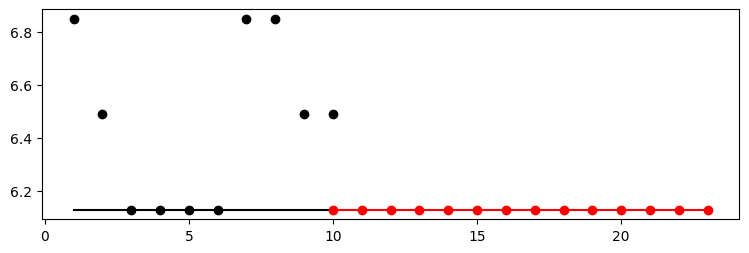

In [22]:
spot_tuner.plot_progress(log_y=False, filename="../Figures.d/" + experiment_name+"_progress.pdf")



* Print the Results

In [23]:
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

| name        | type   | default   |   lower |   upper |                 tuned | transform   |   importance | stars   |
|-------------|--------|-----------|---------|---------|-----------------------|-------------|--------------|---------|
| C           | float  | 1.0       |     0.1 |    10.0 |   0.17186681406008464 | None        |        13.79 | *       |
| kernel      | factor | rbf       |     0.0 |     2.0 |                   2.0 | None        |       100.00 | ***     |
| degree      | int    | 3         |     3.0 |     3.0 |                   3.0 | None        |         0.00 |         |
| gamma       | factor | scale     |     0.0 |     1.0 |                   0.0 | None        |        33.97 | *       |
| coef0       | float  | 0.0       |     0.0 |     0.0 |                   0.0 | None        |         0.00 |         |
| shrinking   | factor | 0         |     0.0 |     1.0 |                   0.0 | None        |         0.00 |         |
| probability | factor | 0         |    

## Show variable importance

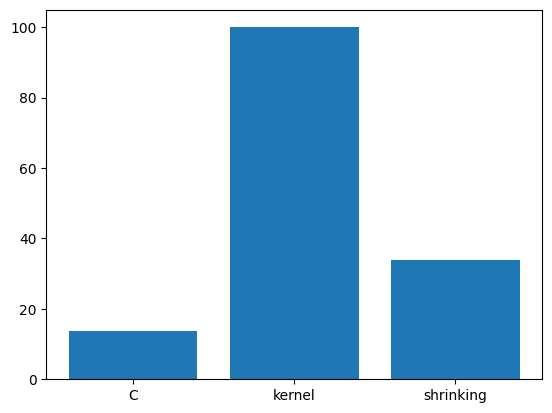

In [24]:
spot_tuner.plot_importance(threshold=0.025, filename="../Figures.d/" + experiment_name+"_importance.pdf")

## Get Default Hyperparameters

In [25]:
values_default = get_default_values(fun_control)
values_default = transform_hyper_parameter_values(fun_control=fun_control, hyper_parameter_values=values_default)
values_default

{'C': 1.0,
 'kernel': 'rbf',
 'degree': 3,
 'gamma': 'scale',
 'coef0': 0.0,
 'shrinking': 0,
 'probability': 0,
 'tol': 0.001,
 'cache_size': 200.0,
 'break_ties': 0}

In [26]:
model_default = make_pipeline(fun_control["prep_model"], fun_control["core_model"](**values_default))
model_default

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(break_ties=0, cache_size=200.0, probability=0,
                     shrinking=0))])

## Get SPOT Results

In [27]:
X = spot_tuner.to_all_dim(spot_tuner.min_X.reshape(1,-1))
print(X)

[[1.71866814e-01 2.00000000e+00 3.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 2.84126191e-03
  2.65066331e+02 1.00000000e+00]]


In [28]:
v_dict = assign_values(X, fun_control["var_name"])
return_conf_list_from_var_dict(var_dict=v_dict, fun_control=fun_control)

[{'C': 0.17186681406008464,
  'kernel': 'rbf',
  'degree': 3,
  'gamma': 'scale',
  'coef0': 0.0,
  'shrinking': 0,
  'probability': 0,
  'tol': 0.0028412619107524967,
  'cache_size': 265.06633094506617,
  'break_ties': 1}]

In [29]:
model_spot = get_one_sklearn_model_from_X(X, fun_control)
model_spot

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=0.17186681406008464, break_ties=1,
                     cache_size=265.06633094506617, probability=0, shrinking=0,
                     tol=0.0028412619107524967))])

## Plot: Compare Predictions

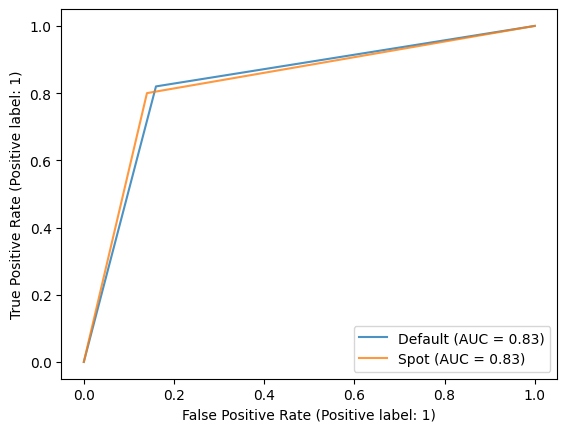

In [30]:
plot_roc([model_default, model_spot], fun_control, model_names=["Default", "Spot"])

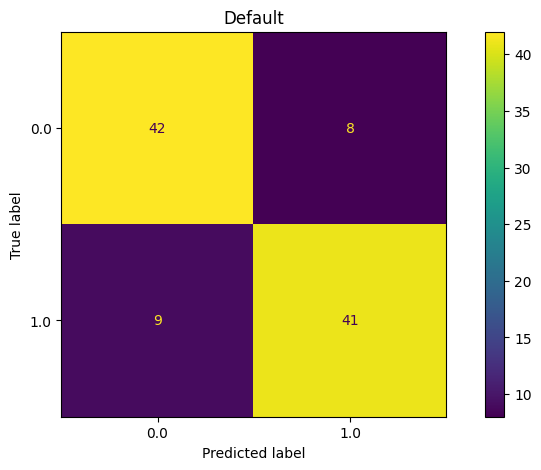

In [31]:
plot_confusion_matrix(model_default, fun_control, title = "Default")

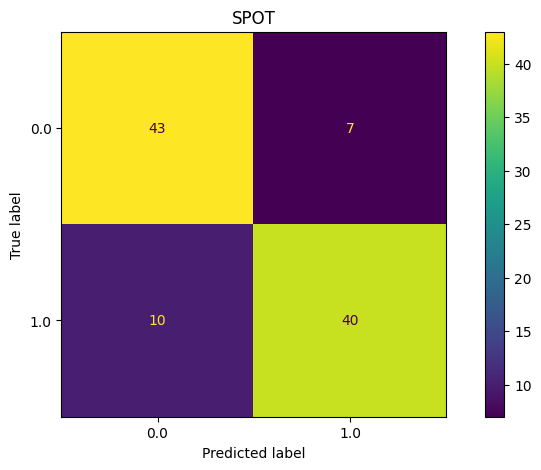

In [32]:
plot_confusion_matrix(model_spot, fun_control, title="SPOT")

In [33]:
min(spot_tuner.y), max(spot_tuner.y)

(6.127421076149916, 6.848294143932259)

## Detailed Hyperparameter Plots

* For productive use, you might want to select:
  * `min_z=min(spot_tuner.y)` and
  * `max_z = max(spot_tuner.y)`
* These settings are not so colorful as visualizations that use `None` for the ranges, but give better insights.

C:  13.794507653477536
kernel:  100.0
shrinking:  33.965176542357675


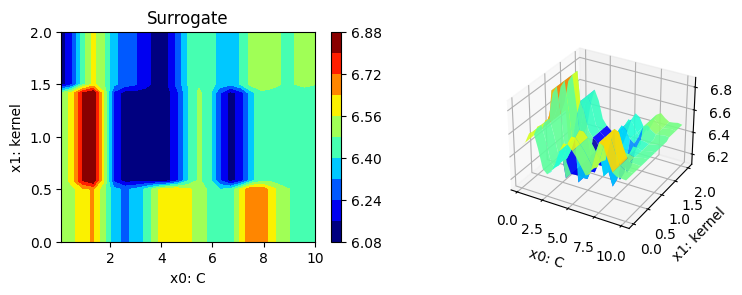

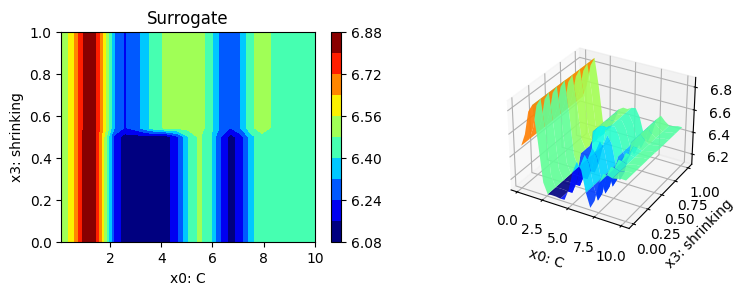

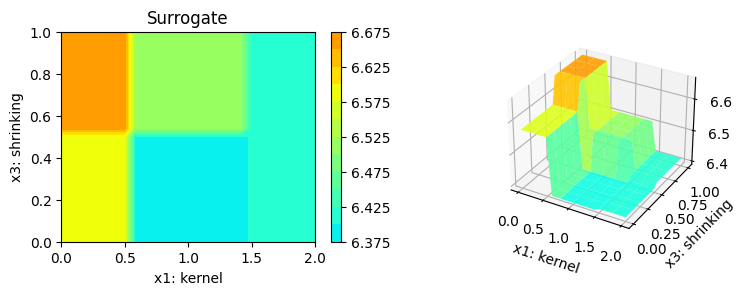

In [34]:
threshold = 0.025
impo = spot_tuner.print_importance(threshold=threshold, print_screen=True)
var_plots = [i for i, x in enumerate(impo) if x[1] > threshold]
min_z = min(spot_tuner.y)
max_z = max(spot_tuner.y)
n = spot_tuner.k
for i in var_plots:
    for j in var_plots:
        if j > i:
            filename = "../Figures.d/" + experiment_name+"_contour_"+str(i)+"_"+str(j)+".pdf"
            spot_tuner.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z, filename=filename)

## Parallel Coordinates Plot

In [35]:
spot_tuner.parallel_plot()

## Plot all Combinations of Hyperparameters

* Warning: this may take a while.

In [36]:
PLOT_ALL = False
if PLOT_ALL:
    n = spot_tuner.k
    for i in range(n-1):
        for j in range(i+1, n):
            spot_tuner.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z)